# **Project - Market Making**

We simulates a basic inventory-aware market-making strategy using order book data from [Bybit.com](https://www.bybit.com/derivatives/en/history-data). We make frequent quotes, tracks fills, updated position and PnL, and log performance on historical data. The primary goal is to gain insight into how passive quoting behaves under inventory and execution constraints in high-frequency data.

We particularly chose `BTCUSDT-26SEP25`, which is a perpetual futures contract. We took the dates 3 months prior to expiry.

In [1]:
pip install ujson

In [2]:
import ujson
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

## Formatting Data

The historical order book data used in this project was downloaded and formatted following the method described in [this article by Lu Battistoni](https://medium.com/@lu.battistoni/how-to-download-and-format-free-historical-order-book-dataset-16b3a84a8e0e).
The `OrderBookLoader` class is designed to efficiently load, parse, and store high-frequency order book data from Bybit, enabling quick access and structured analysis for quantitative research and trading simulations.

In [50]:
class OrderBookLoader:
    """
    Fast order book loader using ujson and numpy
    Stores snapshots (asks and bids) per timestamp.
    """
    def __init__(self, file_path, max_depth=1, rows_to_process=None):
        self.file_path = file_path
        self.max_depth = max_depth
        self.rows_to_process = rows_to_process
        self.nrows = None
        self.order_books = {}  # {timestamp: {'ask': np.array, 'bid': np.array}}
        self.timestamps = []

    def number_of_rows(self):
        """Return total number of lines in the data file."""
        if(self.nrows):
            return self.nrows
        with open(self.file_path, 'r') as f:
            self.nrows = sum(1 for _ in f)
        return self.nrows

    def read_data(self):
        """
        Read up to `rows_to_process` lines, parse JSON via ujson,
        and store top `max_depth` levels in numpy arrays.
        """
        # Determine how many rows to process
        if self.rows_to_process is None:
            self.rows_to_process = self.number_of_rows()

        with open(self.file_path, 'r') as f:
            for _ in tqdm(range(self.rows_to_process), desc="Loading order book "):
                line = f.readline().strip().strip("'")
                if not line:
                    break
                obj = ujson.loads(line)

                ts = obj['ts']
                a = obj['data']['a'][:self.max_depth]
                b = obj['data']['b'][:self.max_depth]

                # skip incomplete snapshots
                if not a or not b:
                    continue

                # store as numpy arrays of shape (depth, 2): [price, volume]
                self.order_books[ts] = {
                    'ask': np.array(a, dtype=np.float64),
                    'bid': np.array(b, dtype=np.float64)
                }
        self.timestamps = list(self.order_books.keys())
        self.timestamps.sort()

### Testing if it works

Let's take an overview of number of data points and general look of the data file

In [51]:
# file name
path = '/content/2025-06-10_BTCUSDT-26SEP25_ob500.txt'

# Instantiate the loader with the file
loader = OrderBookLoader(path, max_depth = 3, rows_to_process = 100000)

# Number of rows
max_n_of_rows = loader.number_of_rows()
print(max_n_of_rows)

# number of datapoints in a second
print(max_n_of_rows / (60 * 60 * 24), "per second")

# Read data from the file
loader.read_data()

# Build a structured order book Dictionary
order_books = loader.order_books
time = loader.timestamps

449923
5.20744212962963 per second


Loading order book : 100%|██████████| 100000/100000 [00:00<00:00, 174622.60it/s]


In [52]:
# bid prices
order_books[time[0]]['bid'][:,0]

array([112367. , 112366.8, 112365. ])

In [53]:
# ask prices
order_books[time[0]]['ask'][:,0]

array([112388.8, 112388.9, 112400.2])

## Helper Classes

The `Order` class is used to create Limit Bid / Ask Orders, and store them later.

In [54]:
# Class for a single order
class Order:
  def __init__(self, Side, Price, Vol, Timestamp):
    # quote = [price,vol,timestamp]
    self.side = Side
    self.price = Price
    self.vol = Vol
    self.timestamp = Timestamp
    # info at the time of order creation

  def __lt__(self, other): # Defining < operation
    # For price-time priority in the heap (buy orders: max-heap, sell orders: min-heap)
    if self.side == 'buy':
        return self.price > other.price if self.price != other.price else self.timestamp < other.timestamp
    else:
        return self.price < other.price if self.price != other.price else self.timestamp < other.timestamp

The `INVENTORY` class tracks active quotes, manages inventory, and computes PnL for a market-making strategy.

This class simulates the internal bookkeeping of a market maker operating on a limit order book.
It records quotes placed on both the bid and ask side, tracks inventory exposure, executes trades based on live market updates, and maintains the profit or loss (PnL).

Its attributes are as follows:

- (dict) active_bids : Active bid quotes keyed by internal index.
- (dict) active_asks : Active ask quotes keyed by internal index.
- (int) index : Sequential counter for quote entries.
- (int) position : Net position held by the market maker (positive for long, negative for short).
- (float) pnl : Realized profit or loss.
- (float) tot_spread : Tracks total spread observed till now (Max possible earnings through Market Making).
- (float) base_vol : Base Volume of each order.
- (list) pnl_history : Stores tuples of (timestamp, PnL) for plotting.
- (int) time_limit : Maximum time a quote is allowed to live before we cancel it (in quote index entries).

The `add_quote` function adds new bid and ask quotes to active memory.

The `execute` function executes quotes if crossed by new trades and updates PnL and position. `bid_traded` and `ask_traded` are boolean parameters to make note if bid / ask can be filled respectively.

In [237]:
class INVENTORY:
  #Initialise the inventory
  def __init__(self, Time_limit = 100):
    # Among all our outstanding bid quotes, the highest bid is the most urgent or likely to get filled.
    # Each quote_dict element {'price', 'vol', 'time'}
    self.active_bids = {} # dict: (index, Order)
    self.active_asks = {} # dict: (index, Order)
    self.index = 0
    self.position = 0 # Positive means we're long, negative means we're short
    self.pnl = 0 # Profit if +ve else -ve
    self.tot_spread = 0
    self.base_vol = 0.001
    self.pnl_values = [0]
    self.spread_values = [0]
    self.trade_history = [0]
    self.time_limit = Time_limit # in terms of indices, later modify it to real-time

  def add_quote(self, bid_quote, bid_vol , ask_quote, ask_vol, current_time):
    self.active_bids[self.index] = Order('buy', bid_quote, bid_vol, current_time)
    self.active_asks[self.index] = Order('sell', ask_quote, ask_vol, current_time)
    # self.index += 1 happens in execute function

  def execute(self, bid_traded, best_bid, ask_traded, best_ask, current_time):
    if self.active_bids and bid_traded and (best_bid is not None):
      rem_ids = []
      for idx, bid in list(self.active_bids.items()):
        # if bid.timestamp + self.time_limit < current_time :
        if idx + self.time_limit < self.index :
            rem_ids.append(idx)
        elif (bid.price >= best_bid):
            rem_ids.append(idx)
            self.position += bid.vol/self.base_vol
            self.pnl -= bid.vol * bid.price
      for id in rem_ids:
        del self.active_bids[id]

    if self.active_asks and ask_traded and (best_ask is not None):
      rem_ids = []
      for idx,ask in list(self.active_asks.items()):
        # if ask.timestamp + self.time_limit < current_time :
        if idx + self.time_limit < self.index :
            rem_ids.append(idx)
        elif (ask.price <= best_ask):
            rem_ids.append(idx)
            self.position -= ask.vol/self.base_vol
            self.pnl += ask.vol * ask.price
      for id in rem_ids:
        del self.active_asks[id]

    self.index += 1
    self.trade_history.append(self.position)
    self.pnl_values.append(self.pnl)

  def mark_to_market(self, best_bid, best_ask):
    if (best_bid is None) or (best_ask is None):
        return self.pnl

    if self.position >= 0:
        # You're long → you’d sell at bid
        return self.pnl + self.position * best_bid
    else:
        # You're short → you’d buy back at ask
        return self.pnl + self.position * best_ask

  def plot_pnl(self):
    times = range(-1,self.index)
    # --- create two side-by-side sub-plots ---
    fig, (ax_l, ax_r) = plt.subplots(
        nrows=1, ncols=2, figsize=(12, 5), sharex=True
    )

    # ---- LEFT:  PnL & theoretical spread ---------------------------------
    ax_l.plot(times, self.pnl_values,      label="PnL (Profit / Loss)",    color='blue')
    ax_l.plot(times, self.spread_values,   label="Spread (Max Theoretical PnL)", color='green', linestyle='--')

    ax_l.set_title("PnL vs. Spread")
    ax_l.set_xlabel("Time (index)")
    ax_l.set_ylabel("Value")
    ax_l.legend()
    ax_l.grid(True)

    # ---- RIGHT:  current position ----------------------------------------
    ax_r.plot(times, self.trade_history, label="Executed Position", color='orange')

    lim = max(abs(min(self.trade_history)), abs(max(self.trade_history)))
    lim = max(lim,30.0)
    ax_r.set_ylim(-lim, lim)
    ax_r.axhline(y=0, color='r', linestyle='--')
    ax_r.set_title("Position")
    ax_r.set_xlabel("Time (index)")
    ax_r.set_ylabel("Position size")
    ax_r.legend()
    ax_r.grid(True)

    # tidy up spacing and show
    plt.tight_layout()
    plt.show()


## Quoting Logic

$$ min\_price : \Delta = 0.1 $$
$$ price\_factor : \alpha = 3.0 $$
$$ Inventory\_bias : \phi = \min(\frac{|I|}{I_{mar}},\alpha) $$

### Price

$$ bid\_quote = best\_bid + \Delta - \lfloor\phi\rfloor . \Delta $$
$$ ask\_quote = best\_ask - \Delta - \lfloor\phi\rfloor . \Delta $$

### Volume

$$ base\_volume : Q_0 = 0.001 $$
$$ vol\_factor : \beta = 0.25 $$
NOTE :
$ \alpha \cdot \beta \lt 1.0 $
$$ $$
$$ bid\_vol = Q_0 (1 - \beta . \phi) $$
$$ ask\_vol = Q_0 (1 + \beta . \phi) $$


- Using `skew = min(abs(inventory_vol / inventory_margin), 1)`, we ensure that skew remains between [-1,1]

- If `skew` > 0 (long), both quotes shift down → makes buying less attractive and selling more tempting.

- If `skew` < 0 (short), both quotes shift up → makes buying more attractive (to cover) and selling less attractive.

- If `market_neutral` is `True`, we ignore all inventory bias. Both bid and ask are sized at base_vol. Otherwise, we scale volumes in the opposite direction of unwanted inventory.

In [247]:
# Using inventory bias and unequal quoting
def quotes(best_bid, best_ask, delta=0.1, pos=0, price_factor=3.0, vol_factor=0.25, base_vol=0.001, inventory_cap=9.9, market_neutral=False):
    '''
    delta : tick_size, we don't quote if spread < 2 * delta
    price_factor : amplifies how much aggresively price is affected by position (>= 1)
    vol_factor : affects how much volume is affected by inventory (needs to be <= 1)
    base_vol : base volume
    inventory_cap : inventory size after which we shoot in methods to control inventory size
    '''
    if (best_bid is None) or (best_ask is None):
        return None

    spread = best_ask - best_bid
    if(spread < 2 * delta): # Only quote if we have a proper spread
        return None

    bid_quote = best_bid + delta
    ask_quote = best_ask - delta

    if market_neutral:
        return bid_quote, base_vol, ask_quote, base_vol # MARKET NEUTRAL

    skew = min(abs(pos / inventory_cap), price_factor)
    if(pos < 0) :
        skew = -skew # Negative skew if we are net short
    skew_price = round(skew * delta * 10)/10 # Price offset

    bid_quote = best_bid + delta - skew_price
    ask_quote = best_ask - delta - skew_price

    bid_vol = base_vol * (1 - vol_factor * skew)
    ask_vol = base_vol * (1 + vol_factor * skew)

    if (bid_vol < 0) or (ask_vol < 0):
        return None

    # Round to tick size if necessary
    return bid_quote, bid_vol, ask_quote, ask_vol

## Market Strategy

- We enumerate through every time stamp of the day and find the `best_bid` and `best_ask`.
- `prev_best_bid` and `prev_best_ask` store the best bid and ask for the order book of the previous day.
- If the best bid has reduced from the previous day or the best ask has increased, that implies if we made a quote at that, our order would get filled.
- This is a heuristic approach. Accordingly, we try all out active bids and asks on the current order book.
- Then, after every `quote_interval` amount of timeframes, we make new quotes.
- `quote_interval` is kept = 1, to maximize the opportunities
- `Volume_factor = 0` essentially implies market neutrality

In [248]:
def hourly_pnl(loader, quote_interval=1, exit_interval=100, Price_factor=3.0, Vol_factor=0.25, inventory_cap=9.9, MARKET_NEUTRAL=False):
    """
    Simulate PnL of one day by iterating over snapshots in order_books.
    Uses numpy arrays directly, no pandas.
    exit_interval : indices of order books before the quote orders are taken back
    Price_factor : affects how much price is affected by inventory (>= 1)
    Vol_factor : affects how much volume is affected by inventory (needs to be <= 1)
    quote_interval : frequency at which we release new quotes
    """
    # Load order books
    order_books = loader.order_books
    times = loader.timestamps

    # Initialize inventory
    inventory = INVENTORY(exit_interval)
    base_vol = inventory.base_vol
    prev_best_bid = prev_best_ask = None

    for idx, t in enumerate(times):
        book = order_books[t]

        # best prices & vols
        if book['bid'].size:
            best_bid = (book['bid'][0,0], book['bid'][0,1])
        else:
            best_bid = None
        if book['ask'].size:
            best_ask = (book['ask'][0,0], book['ask'][0,1])
        else:
            best_ask = None

        # detect trade-through
        bid_traded = False
        ask_traded = False
        if (prev_best_bid) and (best_bid):
            bid_traded = ((best_bid[0] < prev_best_bid[0]) or
                          ((best_bid[0] == prev_best_bid[0]) and (best_bid[1] < prev_best_bid[1])))
        if (prev_best_ask) and (best_ask):
            ask_traded = ((best_ask[0] > prev_best_ask[0]) or
                          ((best_ask[0] == prev_best_ask[0]) and (best_ask[1] < prev_best_ask[1])))

        # execute fills
        inventory.execute(
            bid_traded, best_bid[0],
            ask_traded, best_ask[0],
            idx
        )

        prev_best_bid, prev_best_ask = best_bid, best_ask

        # quote every N steps
        if (idx % quote_interval == 0) and (best_bid is not None) and (best_ask is not None):
            new_quotes = quotes(best_bid[0], best_ask[0],
                                delta=0.1,
                                pos=inventory.position,
                                price_factor=Price_factor,
                                vol_factor=Vol_factor,
                                base_vol=base_vol,
                                inventory_cap=inventory_cap,
                                market_neutral=MARKET_NEUTRAL)
            if new_quotes:
                bid_q, bid_v, ask_q, ask_v = new_quotes
                if (bid_q is not None) and (ask_q is not None):
                    inventory.add_quote(bid_q, bid_v, ask_q, ask_v, t)

        # PnL logging
        inventory.tot_spread += (best_ask[0] - best_bid[0]) * inventory.base_vol
        inventory.spread_values.append(inventory.tot_spread)

    # final metrics
    print(f"Final Inventory: {round(inventory.position,2)} | Final PNL: {round(inventory.pnl,2)}")
    print(f"PNL to Spread Ratio: {inventory.pnl * 100/ inventory.tot_spread:.4f}%")
    inventory.plot_pnl()
    # return inventory.pnl

## Analysis

The blue line shows a steadily increasing PnL with some volatility, while the orange dashed line reflects cumulative spread capture, which is the theoretical maximum pnl for a Neutral Market Making.

A PnL-to-Spread ratio of 0.75 indicates efficient spread capture, with 75% of observed spread converted into profit.

Loading order book : 100%|██████████| 50000/50000 [00:00<00:00, 108601.30it/s]


Final Inventory: 6.0 | Final PNL: 3249.62
PNL to Spread Ratio: 68.2617%


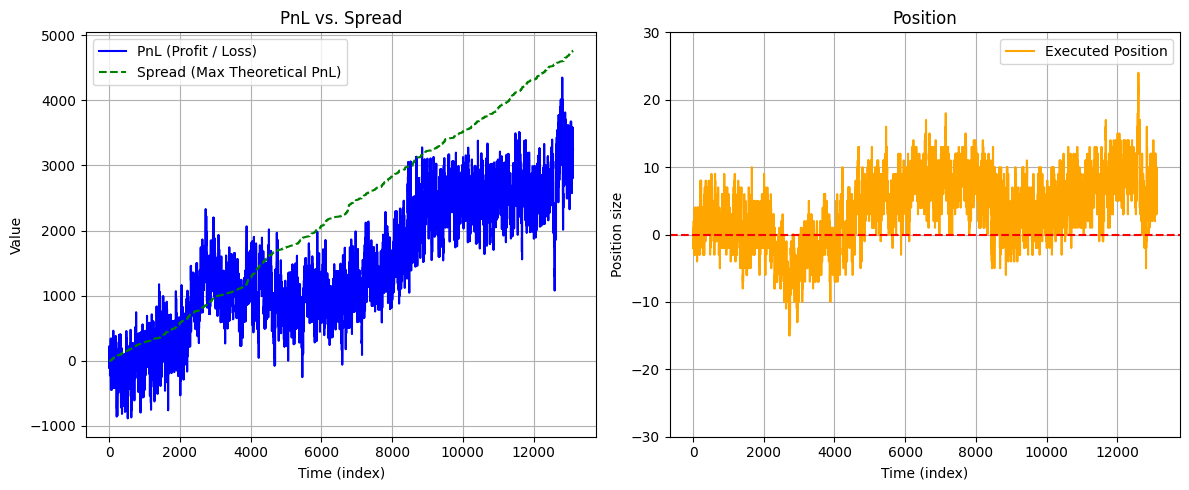

In [249]:
path = '/content/2025-06-10_BTCUSDT-26SEP25_ob500.txt'
loader = OrderBookLoader(path, rows_to_process = 50000)
loader.read_data()
hourly_pnl(loader, exit_interval=200, MARKET_NEUTRAL=True) # NAIVE MARKET MAKING

Final Inventory: -2.09 | Final PNL: 14495.39
PNL to Spread Ratio: 80.0983%


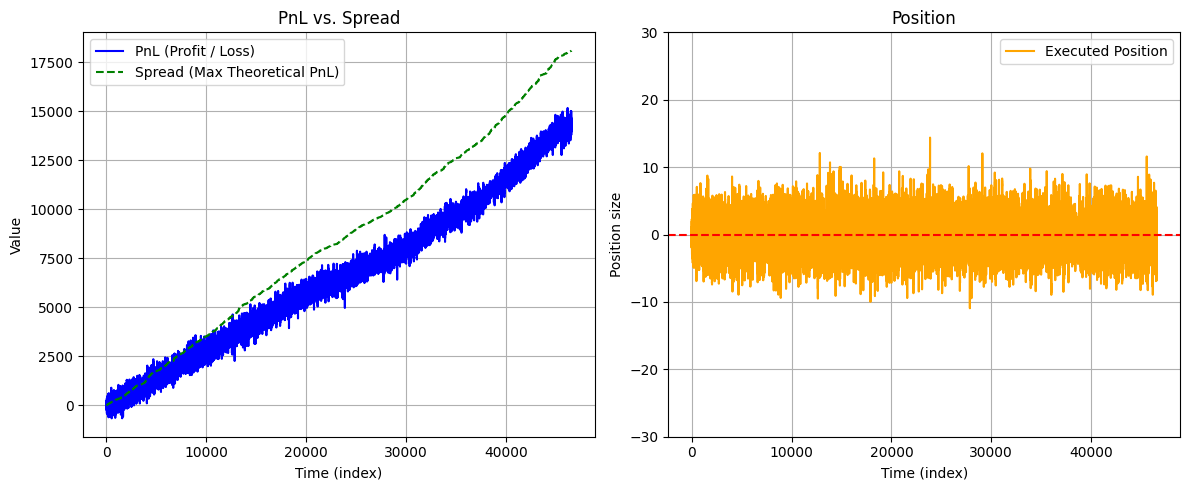

In [255]:
hourly_pnl(loader,exit_interval=200) # INVENTORY AWARE STRATEGY

After playing around with the HyperParameters --- `Price_factor`, `Vol_factor`, `inventory_cap`. we give some conclusions :

- Increasing the `Price_factor` (integer values) gives space for stronger price changes according to the bias. But a value of `Price_factor` $ \gt 4 $ would give really big price differences.

- For a fixed pair of `Price_factor` and `Vol_factor`, there exists an optimal value of `inventory_cap` above which the `Final_PNL` remains constant.

- we get a good PNL to Spread Ratio for these HyperParameters :
  - Price_factor=3.0
  - Vol_factor=0.025
  - Max_inventory=15.0

Final Inventory: -2.25 | Final PNL: 15158.59
PNL to Spread Ratio: 83.7630%


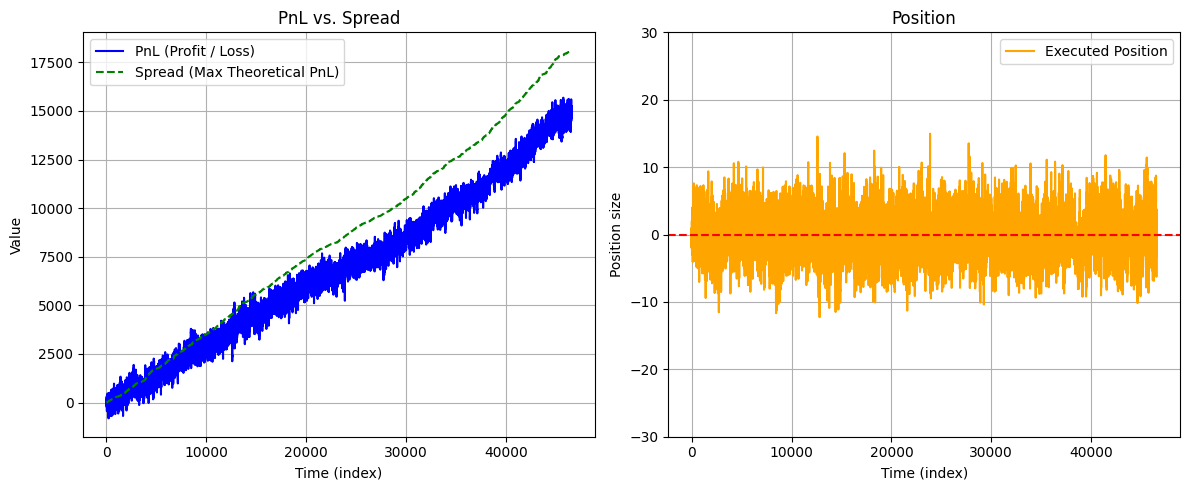

In [256]:
hourly_pnl(loader,exit_interval=200, Price_factor=3.0, Vol_factor=0.025, inventory_cap=15.0) # INVENTORY AWARE STRATEGY

### Let's see if it works on a Longer Duration

Loading order book : 100%|██████████| 200000/200000 [00:01<00:00, 160827.68it/s]


Final Inventory: -2.25 | Final PNL: 15158.59
PNL to Spread Ratio: 83.7630%


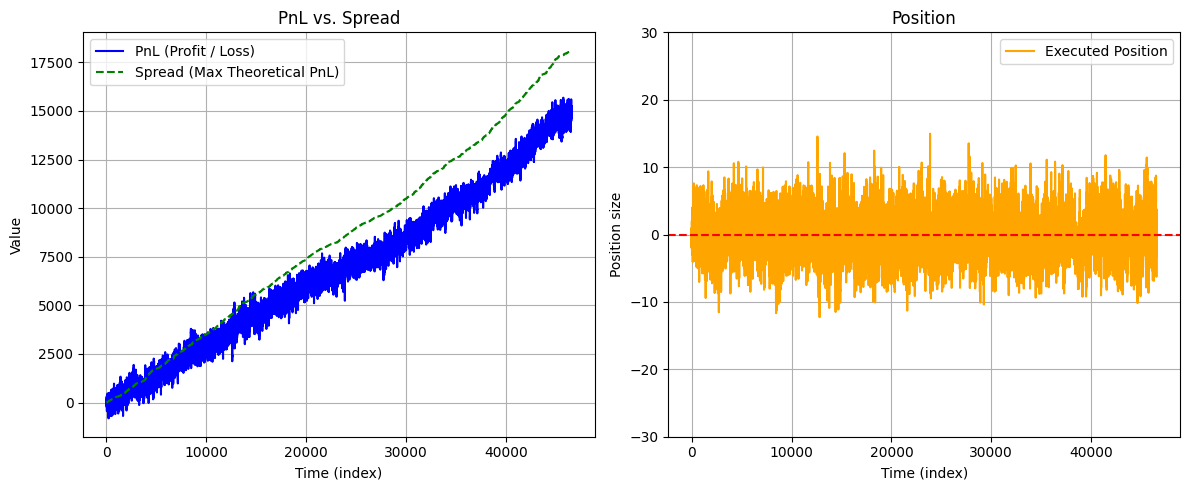

In [254]:
loader = OrderBookLoader(path, rows_to_process = 200000)
loader.read_data()
hourly_pnl(loader,exit_interval=200, Price_factor=3.0, Vol_factor=0.025, inventory_cap=15.0)

we got a really good performance for the entire day

**Let's see if it works decently on the next day for the same instrument**

Loading order book : 100%|██████████| 200000/200000 [00:01<00:00, 124935.15it/s]


Final Inventory: 1.32 | Final PNL: 11114.68
PNL to Spread Ratio: 76.9084%


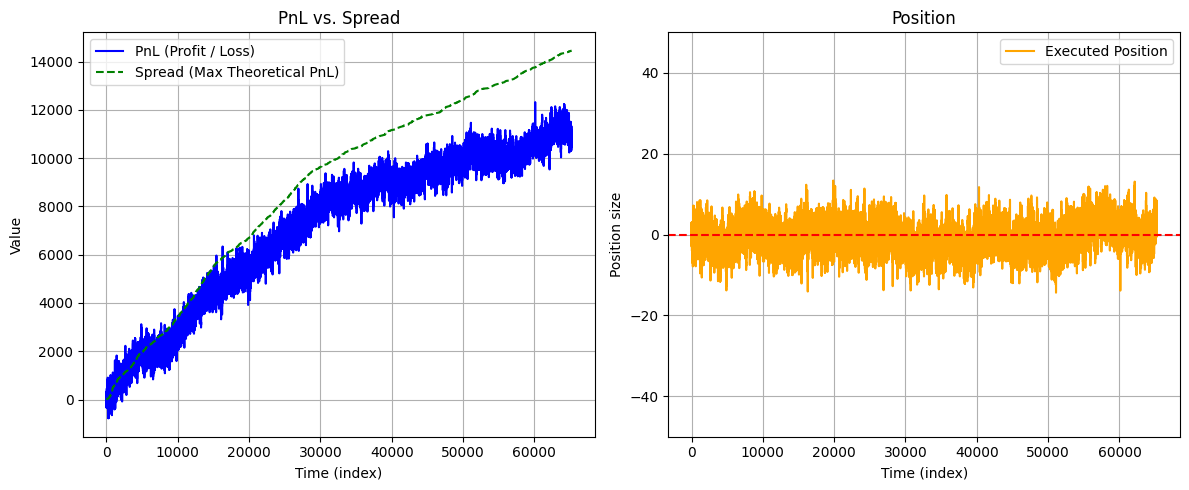

In [201]:
path2 = '/content/2025-06-11_BTCUSDT-26SEP25_ob500.txt'
loader2 = OrderBookLoader(path2, rows_to_process = 200000)
loader2.read_data()
hourly_pnl(loader2,exit_interval=200, Price_factor=3.0, Vol_factor=0.015, inventory_cap=12.0)

### Day after the next day

Loading order book : 100%|██████████| 200000/200000 [00:01<00:00, 137768.18it/s]


Final Inventory: 9.37 | Final PNL: 7634.52
PNL to Spread Ratio: 60.9675%


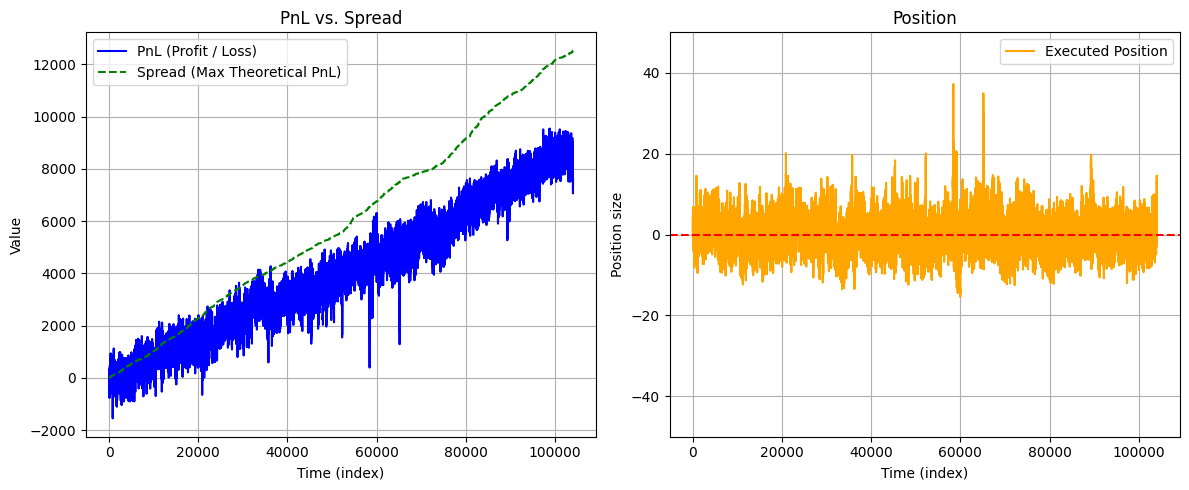

In [202]:
path3 = '/content/2025-06-12_BTCUSDT-26SEP25_ob500.txt'
loader3 = OrderBookLoader(path3, rows_to_process = 200000)
loader3.read_data()
hourly_pnl(loader3,exit_interval=200, Price_factor=3.0, Vol_factor=0.005, inventory_cap=12.0)

After some days, the effectiveness of the parameters may reduce ... and we might tweak them to give better results

Final Inventory: -2.46 | Final PNL: 8302.93
PNL to Spread Ratio: 66.3053%


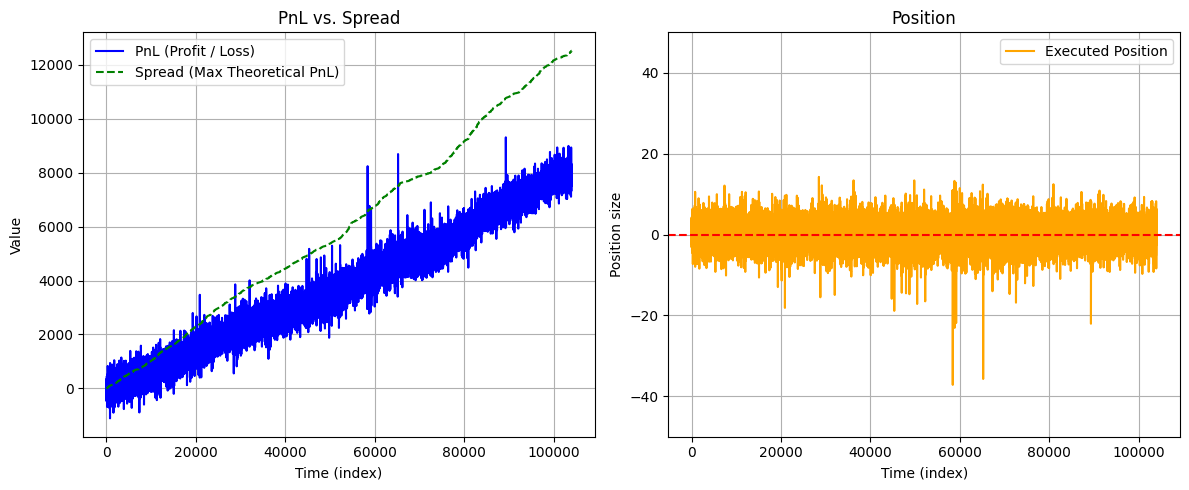

In [227]:
hourly_pnl(loader3,exit_interval=200, Price_factor=3.0, Vol_factor=0.2, inventory_cap=8.0)